## The primary goal of this project is to determine if we can use ebird to automate updates to the IBA database. Our approach is broken into the following parts:

### 1. Exploratory Analysis
####    a. Determine number of IBA sites and the status of these sites (pending, etc) and investigate discrepencies between the GIS data and IBA database
####    b. Determine percent of sites and species that fall under each criteria code


### 2. Analysis of IBA criteria code categories
####    a. Identify information needed to update species info in each category
####    b. Obtain and organize different data sources
####    c. Identify what sites and species need updating


### 3. Set up process to update IBA data with ebird
####    a. Automate update according to state


# Part 1: Exploratory Analysis
##### What can we tell from just looking at this data? 

#### a. Determine number of IBA sites and the status of these sites 

Problem 1: Some of these sites are duplicated but assigned unique Site_ID numbers and not all of these sites are recognized. In other words, the status of some sites are Rejected, Nominated, Merged, Pending, Potential, Delisted, or Identified. 
Solution: Remove duplicates and those sites that are not recognized. 


Problem 2: Not all of these sites have a species observation, and therefore a criteria listing. 
Solution: Filter down site data in access to all the unique, recognized sites, with species observations (site species criteria status Query). 



#### Results:
According to dob_Site on the IBA Access Database, there are 3950 sites. Removing duplicates, there are 3895 unique sites. Removing those sites that have not been recognized, there are XXX recognized unique sites. Of the recognized sites, XXX have a species observation with a criteria code. 

##### To summarize, not all dbo_sites on the IBA database have a criteria code assignment or species information. Sometimes they have one or the other, both, or none. We may not be able to use ebird to assign criteria codes, but we can certainly use ebird to determine which species are present at a particular site. 

The R script to come up with each of these evaluations is provided below. 

In [ ]:
library("plyr")
library("ggplot2")
library("dplyr")
library("data.table")

setwd("~/IBA_Update/IBA_Database/Corrected_Queries")

# Import raw dbo_Sites from IBA_Database in Access
Query <- read.csv("Site_Status_Query.csv", header = TRUE, sep = ",")
Num_dbo_Sites <- nrow(Query)  # 3950 Total Sites

# Remove the dbo_Site entries that are duplicated
UniqueSites <- Query[!duplicated(Query[2]),] # 3894 Unique sites
UniqueSites$Description <- as.character(UniqueSites$Description) 
UniqueSites$Description[UniqueSites$Description == ""] <- "No Status"  # Label sites with no status
UniqueSites$Description <- as.factor(UniqueSites$Description)
Num_Uniquesites <- nrow(UniqueSites) 


# Table of Sites in each Status Category and plot number of unique sites in each category
SiteStatus <- data.frame(table(UniqueSites$Description)) # 2423 Recognized Unique Sites
colnames(SiteStatus)[colnames(SiteStatus)=="Var1"] <- "Status" 

  ggplot(UniqueSites, aes(x = UniqueSites$Description)) +
    xlab("Status") + ylab("Number of Unique Sites") + ggtitle("Number of Sites per Status Type") +
    theme(plot.title = element_text(size = 24, face = "bold"), axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14)) +
    geom_bar()


# Make new dataframe with only recognized sites and plot recognized sites in each state
Recognized_UniqueSites <- UniqueSites[UniqueSites$Description == 'Recognized',]
State_Sites <- data.frame(table(Recognized_UniqueSites$Abbreviation))
colnames(State_Sites)[colnames(State_Sites)=="Var1"] <- "State" 

  ggplot(Recognized_UniqueSites, aes(x = Recognized_UniqueSites$Abbreviation)) +
    xlab("State") + ylab("Number of Sites") + ggtitle("Number of Recognized Unique Sites per State") +
    theme(plot.title = element_text(size = 24, face = "bold"), axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14)) +
    geom_bar()

Num_UniqueRecognized <- nrow(Recognized_UniqueSites) 

# Find number of Unique Recognized Sites that have an assigned criteria code
Site_Status_Criteria <- read.csv("Site_Status_Criteria_Query.csv", header = TRUE, sep=",")
Unique_SSC <- Site_Status_Criteria[!duplicated(Site_Status_Criteria[2]),]
Site_Criteria_Recognized <- Unique_SSC[Unique_SSC$Description == 'Recognized',]
Num_UniqueCriteria_Sites <- nrow(Unique_SSC)


# Make new dataframe with number of unique recognized sites per criteria code
CodeCategory_UniqueRecognized <- Site_Criteria_Recognized[!duplicated(Site_Criteria_Recognized[2:4]),]# remove duplicates
  
  ggplot(CodeCategory_UniqueRecognized, aes(x=CodeCategory_UniqueRecognized$Code)) +
    xlab("Code Category") + ylab("Number of Sites") + ggtitle("Number of Recognized Unique Sites per Code Category") +
    theme(plot.title = element_text(size = 24, face = "bold"), axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14)) +
    geom_bar()

CodeCategory_Table <- data.frame(table(CodeCategory_UniqueRecognized$Code))
colnames(CodeCategory_Table)[colnames(CodeCategory_Table)=="Var1"] <- "Code" 




# LIST OF ALL & RECOGNIZED SITES WITH CRITERIA THAT DO NOT HAVE SPECIES INFORMATION
SpeciesSites <- read.csv("Site_Species_Status_Criteria.csv", header = TRUE, sep=",")
Unique_SpeciesSites <- SpeciesSites[!duplicated(SpeciesSites[2]),]
Recognized_SpeciesSites <- Unique_SpeciesSites[Unique_SpeciesSites$dbo_Status_Description == 'Recognized',]
Num_Recognized_SpeciesSites <- nrow(Recognized_SpeciesSites)

Rec_SppSite_List <- subset.data.frame(Recognized_SpeciesSites[2],)
Rec_SSC_List <- subset.data.frame(Site_Criteria_Recognized[2],)
ALL_SppSite_List <- subset.data.frame(Unique_SpeciesSites[2],)
ALL_SSC_List <- subset.data.frame(Unique_SSC[2],)

ALL_SITES_MISSING_SPECIES <- anti_join(ALL_SSC_List,ALL_SppSite_List)
Recognized_SITES_MISSING_SPECIES <- anti_join(Rec_SSC_List,Rec_SppSite_List)
Num_Recognized_missing <- nrow(Recognized_SITES_MISSING_SPECIES)
Num_ALL_missing <- nrow(ALL_SITES_MISSING_SPECIES)


###############################################################
## Count Results!!!
###############################################################

cat(paste0("No. of dbo_Sites listed in IBA_Database: ", Num_dbo_Sites, "\n",
           "No. of unique sites listed in IBA_Database: ", Num_Uniquesites, "\n",
           "No of unique, recognized sites in IBA_Database: ", Num_UniqueRecognized, "\n",
           "No. of unique sites with a criteria code: ", Num_UniqueCriteria_Sites, "\n",
           "No. of unique, recognized sityes in IBA that have SPP info: ", Num_Recognized_SpeciesSites, "\n",
           "No. of unique, recognized sites with criteria missing SPP info: ", Num_Recognized_missing, "\n",
           "No. of all unique sites with criteria missing SPP info: ", Num_ALL_missing))


print(SiteStatus)

print(CodeCategory_Table)

#### Summary of IBA Site Information:
No. of dbo_Sites listed in IBA_Database: 3950
No. of unique sites listed in IBA_Database: 3894
No of unique, recognized sites in IBA_Database: 2423
No. of unique sites with a criteria code: 2585
No. of unique, recognized sityes in IBA that have SPP info: 1424
No. of unique, recognized sites with criteria missing SPP info: 688
No. of all unique sites with criteria missing SPP info: 965

####    b. Determine percent of sites and species that fall under each criteria code


The following script was run in R to determine what percent of species and sites in the IBA database (those that have species information) have been classified according to certain criteria that were used to designate the IBAs. The output is a visual representation in the form of a bar graph where the x axis indicates criteria category and the y axis indicates the percent of species (or sites) that were classified according to that criteria. 



Warning message in Ops.factor(left, right):
"'/' not meaningful for factors"Warning message in Ops.factor(left, right):
"'/' not meaningful for factors"

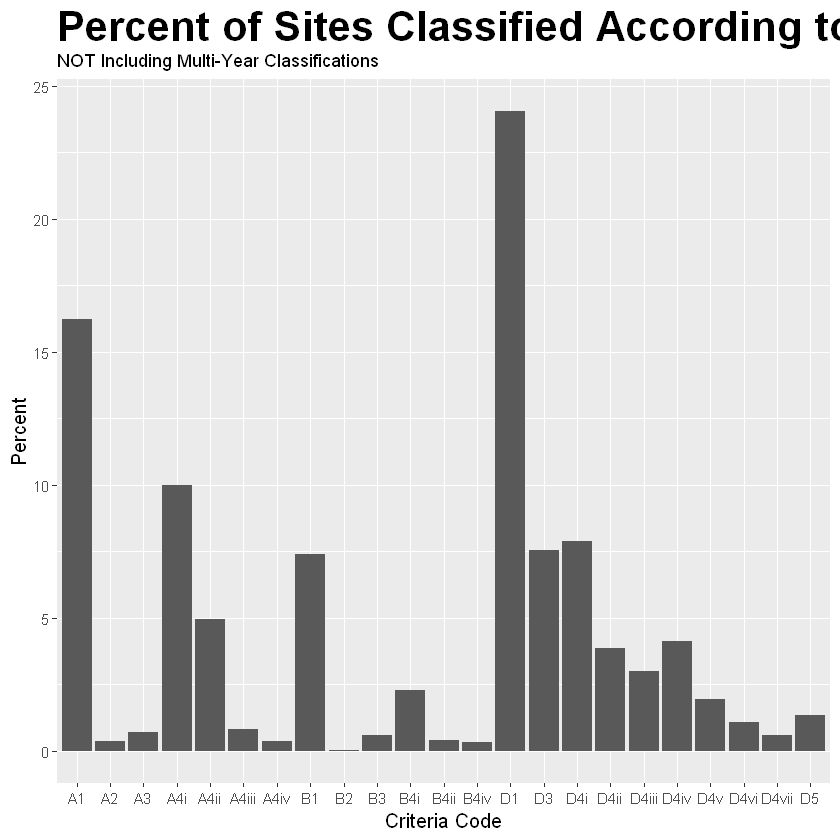

Warning message in Ops.factor(left, right):
"'/' not meaningful for factors"

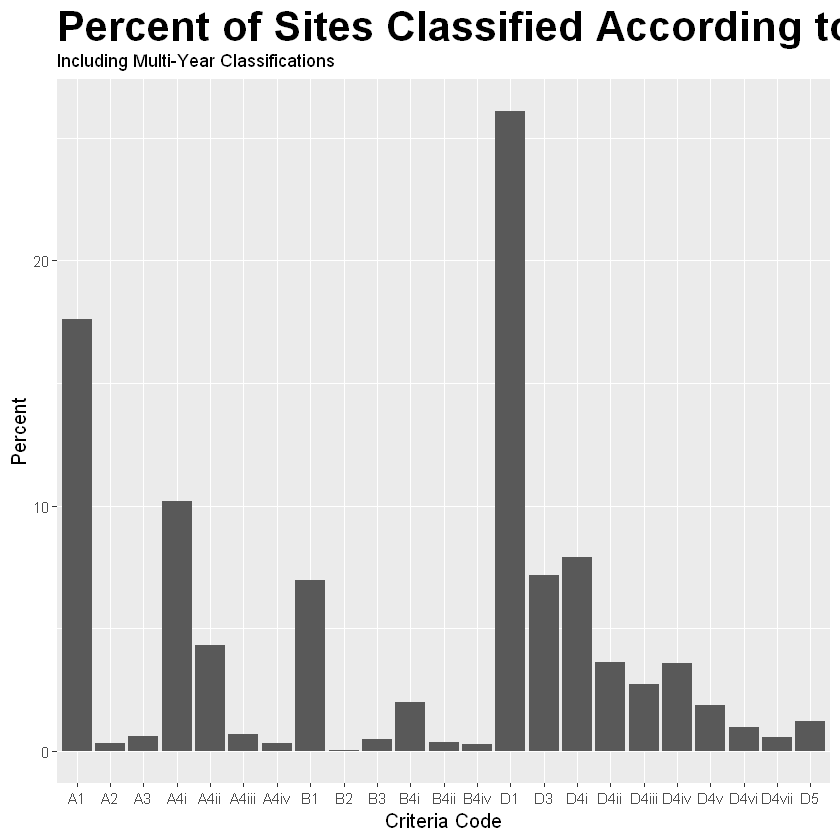

Warning message in Ops.factor(left, right):
"'/' not meaningful for factors"

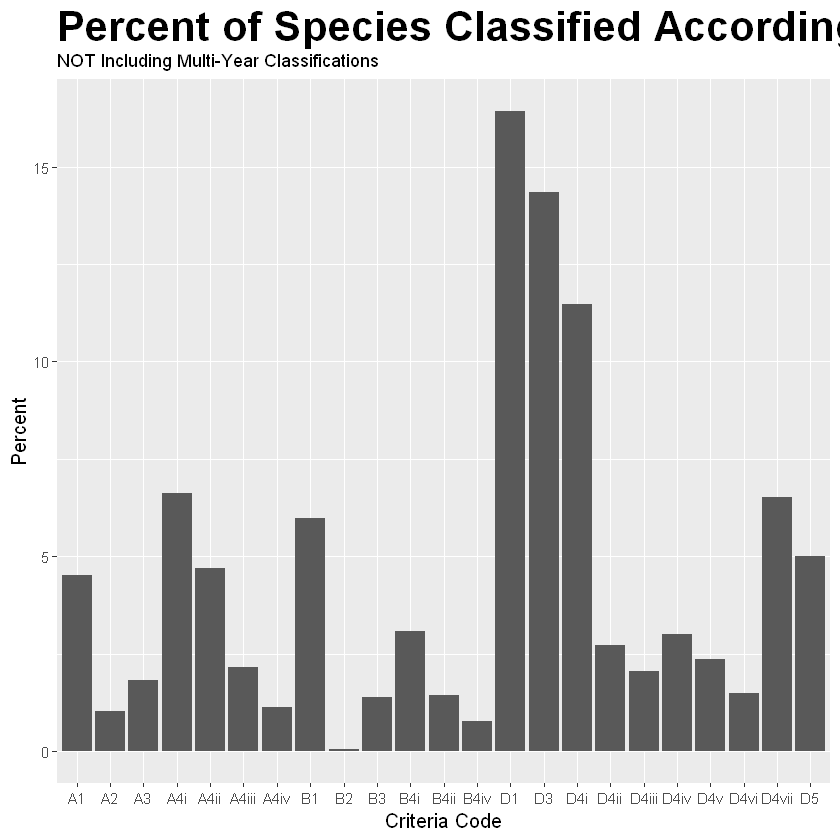

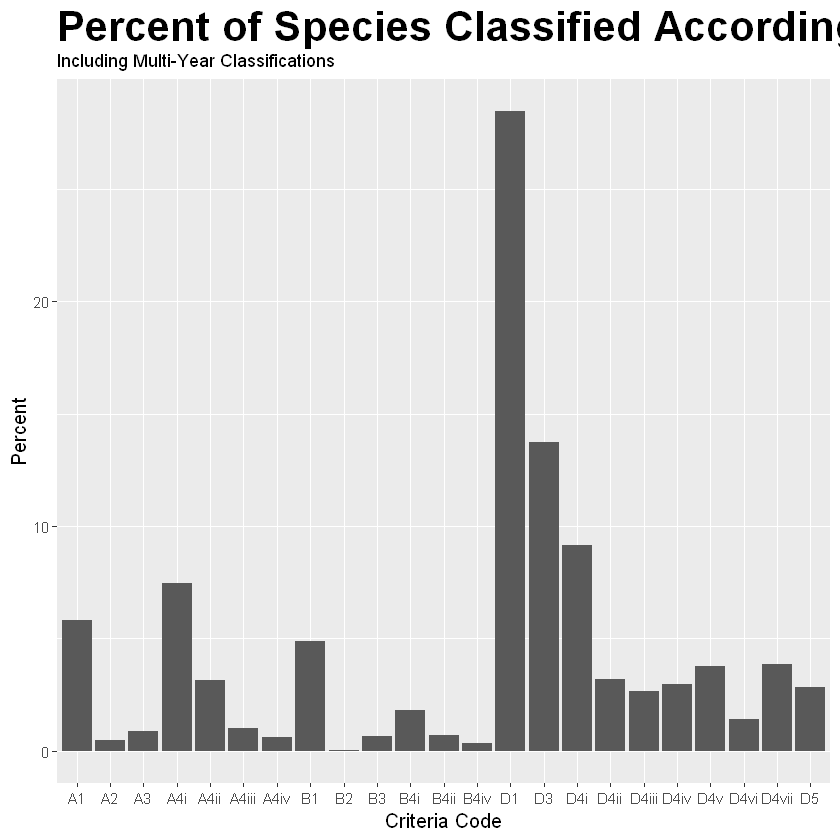

In [5]:
## Access this script in ImportantBirdAreas > Data > SpeciesDataUpdate > 
## SpeciesUpdate_Scripts > CriteriaPercentage_Calculations.R

#setwd("~/IBA_Internship")
#library(devtools)
#library(dplyr)
#library(ggplot2)
#library(shiny)
#library(statsr)
#library(ISLR)


## Duplicated value problem: Several sites with the same criteria code were recorded more than once. In some cases, this was because different years of assignment
## were included. So, I ran it both ways: with and without duplicated assignment across years. For instance, Little River Bottoms was assigned D1 twice in 2008 and
## twice in 2011. So in Unique_CCSite_Combo, all replicated D1s are removed for Little River Bottoms. In Unique_CCSite_Year_combo, one was kept for each year (thus
## resulting in two D1 assignments). Some sites were assigned more than 1 criteria code, I treated these as separate assignments.

## SPECIAL NOTE: For the calculations that include duplicates of the classification codes for different sampling years, missing year values
## were treated as a separate. These were kept as missing dates were assumed to be separate observation. 




######## Import Data From CSV ########
data = read.csv("CriteriaQuery.csv", header = TRUE, sep = ",")
colnames = names(data)

###### CLASSIFICATION PERCENTAGES FOR SITE. MULTIPLE YEARS NOT INCLUDED ######
Unique_CCSite_Combo = data[!duplicated(data[5:6]),] # Get rid of duplicated sites with the same site name and criteria code. Different sampling years not included.
num_cc = data.frame(count(Unique_CCSite_Combo, Criteria_Code))
num_site_assignments = nrow(Unique_CCSite_Combo)
percent_cc = (num_cc/num_site_assignments)*100
CC_Percentages = cbind(num_cc, percent_cc[,2])
names(CC_Percentages)[3] <- "percentage"
CC_Percentages = arrange(CC_Percentages, desc(percentage))
## Plot ##
ggplot(CC_Percentages, aes(x = CC_Percentages$Criteria_Code, y = CC_Percentages$percentage)) +
  xlab("Criteria Code") + ylab("Percent") + ggtitle("Percent of Sites Classified According to Criteria Code", subtitle = "NOT Including Multi-Year Classifications") +
  theme(plot.title = element_text(size = 25, face = "bold"), axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12)) +
  geom_bar(stat = "identity")




###### CLASSIFICATION PERCENTAGES FOR SITE. MULTIPLE YEARS INCLUDED ######
Unique_CCSite_Year_Combo = data[!duplicated(data[c(5:6,11)]),] # Get rid of duplicated sites with same site name, criteria code, and year. Different sampling years included.
num_cc_yrs = data.frame(count(Unique_CCSite_Year_Combo, Criteria_Code))
num_site_assignments_yrs = nrow(Unique_CCSite_Year_Combo)
percent_cc_yrs = (num_cc_yrs/num_site_assignments_yrs)*100
CC_Percentages_yrs = cbind(num_cc_yrs, percent_cc_yrs[,2])
names(CC_Percentages_yrs)[3] <- "percentage"
## Plot ##
ggplot(CC_Percentages_yrs, aes(x = CC_Percentages_yrs$Criteria_Code, y = CC_Percentages_yrs$percentage)) +
  xlab("Criteria Code") + ylab("Percent") + ggtitle("Percent of Sites Classified According to Criteria Code", subtitle = "Including Multi-Year Classifications") +
  theme(plot.title = element_text(size = 25, face = "bold"), axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12)) +
  geom_bar(stat = "identity")

################## Same code for sites but adjusted to be for species ##############################################################################
####################################################################################################################################################

###### CLASSIFICATION PERCENTAGES FOR SPECIES. MULTIPLE YEARS NOT INCLUDED ######
Unique_CCSpecies_Combo = data[!duplicated(data[c(5,8)]),] # Get rid of duplicates with the same speices ID and Criteria Code. Different sampling years not included.
num_cc = data.frame(count(Unique_CCSpecies_Combo, Criteria_Code))
num_site_assignments = nrow(Unique_CCSpecies_Combo)
percent_cc = (num_cc/num_site_assignments)*100
CCSpecies_Percentages = cbind(num_cc, percent_cc[,2])
names(CCSpecies_Percentages)[3] <- "percentage"
CCSpecies_Percentages = arrange(CCSpecies_Percentages, desc(percentage))
## Plot ##
ggplot(CCSpecies_Percentages, aes(x = CCSpecies_Percentages$Criteria_Code, y = CCSpecies_Percentages$percentage)) +
  xlab("Criteria Code") + ylab("Percent") + ggtitle("Percent of Species Classified According to Criteria Code", subtitle = "NOT Including Multi-Year Classifications") +
  theme(plot.title = element_text(size = 25, face = "bold"), axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12)) +
  geom_bar(stat = "identity")


###### CLASSIFICATION PERCENTAGES FOR SPECIES. MULTIPLE YEARS INCLUDED ######
Unique_CCSpecies_Year_Combo = data[!duplicated(data[c(5,8,11)]),] # Get rid of duplicated sites with same site name, criteria code, and year. Different sampling years included.
num_cc_yrs = data.frame(count(Unique_CCSpecies_Year_Combo, Criteria_Code))
num_site_assignments_yrs = nrow(Unique_CCSpecies_Year_Combo)
percent_cc_yrs = (num_cc_yrs/num_site_assignments_yrs)*100
CCSpecies_Percentages_yrs = cbind(num_cc_yrs, percent_cc_yrs[,2])
names(CCSpecies_Percentages_yrs)[3] <- "percentage"
## Plot ##
ggplot(CCSpecies_Percentages_yrs, aes(x = CCSpecies_Percentages_yrs$Criteria_Code, y = CCSpecies_Percentages_yrs$percentage)) +
  xlab("Criteria Code") + ylab("Percent") + ggtitle("Percent of Species Classified According to Criteria Code", subtitle = "Including Multi-Year Classifications") +
  theme(plot.title = element_text(size = 25, face = "bold"), axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12)) +
  geom_bar(stat = "identity")


From step 1, we can see that most sites were classified according to D1 and A1 criteria. We can also see that most species were classified according to D1, D3, and D4i criteria. 

### Ultimately, this step provided valuable information regarding which criteria categories were used most frequently to designate IBAs. 

*******************************************************************************************************************************

*******************************************************************************************************************************

       
# Part 2: Analysis of IBA criteria code categories

##### Do the IBAs listed for each criteria still meet the requirements of that criteria? 


####    a. Identify information needed to update species info in each category
Each site is assigned a criteria code based on characteristics of the species that have been observed at that site. In order to update the IBA species information, it is critical to identify the data sources required for the update of species in each criteria code. Moving forward, the best approach is to divide the update according to criteria code. We first analyze what is needed to update the species that fall into the A criteria code categories. 

## Global IBA Criteria A1: Sites that are known or thought regularly to hold significant numbers of a globally threatened species.

##### This site qualifies if it holds a population of species categorized by the IUCN RED LIST as Critically Endangered, Endangered, or Vulnerable. If a species falls under the vulnerable category, the IBA site must have "more than threshold numbers of that species." 
        
        
#### Information Needed to Update A1 IBA Sites:
1. An Updated IUCN Red List CSV
2. Threshold values for each vulnerable species in the IBA database
3. Ebird database
4. GIS shape file containing polygons that enclose each IBA site


#### Information Needed to Update A4 IBA Sites:
1. Current population estimates for each A4 species 
2. TBD

####    b. Obtain and organize different data sources:

##### 1. An Updated IUCN Red List CSV
We reached out to the IUCN at redlist@iucn.org. They provided us separate csv files that contained common names and the threat status for each species on the redlist. To make one comprehensive list with common name, I put both into an access database and ran a query to produce one csv sheet that contained common name and threat status. I then wrote a script in R that searches each IBA species according to common name and assigns a threat status if it is currently listed. If it is not, I simply assigned in the value "not listed." This code is provided below. 

filepath:

##### 2. Threshold values for each vulnerable species in the IBA database
We reached out to Zoltan Waliczky at aliczky@birdlife.org. He put us into contact with Friederike Richter at friederike.richter@birdlife.org who we are currently waiting on to provide a list of threshold values for each vulnerable species in North America. 

filepath:
        

##### 3. Ebird database
The ebird database is located on the server. Due to the size of the txt file, it was necessary to run an r script that filters out the information you need from ebird. We need all species information from ebird for each site, so we had to obtain the x min, y min, x max, y max coordinates from the GIS file (described below in step 4). Filtering each site individually out of the entire ebird database would have taken weeks. So I applied a filter that would take all ebird entries from the last 10 years, and separate them out into smaller, more manageable, files according to state. 

The 50 files of ebird observations separated by state then served as the input data to be filtered according to IBA site (described further in step 4). 

filepath: box > ImportantBirdAreas > Data > SpeciesDataUpdate> SpeciesUpdateScripts

In [1]:
## Filter Ebird by state

library("dplyr")
library(tidyverse)
library(auk)
library(data.table)
install.packages("snowfall")
install.packages("snow")
library(snowfall)
library(snow)


# Set temporary directory
write("TMP = 'G:/Temp'", file=file.path(Sys.getenv('R_USER'), '.Renviron'))

# set working directory and see what's inside
ebd_dir <- "F:/eBird/Dec2018Clean"
setwd(ebd_dir)
dir()

# set ebird ebd count file
f_ebd <- file.path(ebd_dir, "ebd_relDec-2018.txt")

# create your filters that will be filter the ebd and sampling files
states = c("US-OK","US-OR","US-PA","US-RI","US-SC","US-SD","US-TN","US-TX","US-UT","US-VT","US-VA",
           "US-WA","US-WV","US-WI","US-WY")
i = 1
for (i in 1:length(states)) {
  # define the stuff you want to keep
  target_bbox <- c()
  target_bcr <- c()
  target_country <- c("US")
  target_date <- c("2009-01-01", "2019-01-01")
  target_distance <- c()
  target_duration <- c()
  target_extent <- c()
  target_protocol <- c()
  target_species <- c()
  target_state <- c(states[i])
  target_time <- c()
  
  ebd_filters <- auk_ebd(file = f_ebd, sep = "\t") %>%
    auk_country(country=target_country) %>% 
    auk_date(date=target_date) %>% 
    auk_state(state=target_state) %>%
    auk_complete()
  
  # define the filtered output files and run the filtering step
  f_out_ebd <- paste0("G:/IBA_Update/Ebird_Filtering/Outputs/State_Filters/ebd_10yrs_",states[i],".txt")
  
  ebd_sed_filtered <- auk_filter(ebd_filters, file=f_out_ebd, 
                                 overwrite = TRUE)
   i = i + 1

}


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1     v readr   1.3.1
v tibble  2.1.1     v purrr   0.3.2
v tidyr   0.8.3     v stringr 1.4.0
v ggplot2 3.1.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


ERROR: Error in library(auk): there is no package called 'auk'


##### 4. GIS shape file containing polygons that enclose each IBA site
This information was obtained from the Important Bird Areas folder on box. I opened the shp file in GIS and calculated the minimum bounding geometry to obtain a rectangle that enclosed each polygon. I then calculated the extent of each rectangle to obtain the min and max lat and longitude for each IBA. 

arcpy.MinimumBoundingGeometry_management('US_IBAs_2018Feb',"G:\IBA_Update\GIS\Bounding\Output", "RECTANGLE_BY_AREA", None)

arcpy.AddGeometryAttributes_management('Output', 'EXTENT')

arcpy.TableToExcel_conversion("MyProject.gdb/US_IBAs_2018Feb_Project_Mini", "MinMaxLatLong.xls"


With a csv sheet containing the min/max lat and long for each site, there were approximately 2800 rows that each corresponded to a site within a state. Because it took too long to filter each site out of the ebird database, I divided this csv sheet into 50 smaller csv sheets that were organized by state. I then applied these geographic filters to the ebird files separated by state and as a result, it took two days to obtain a folder for each state that contained all ebird observations per site. 

filepath: box > ImportantBirdAreas > Data > SpeciesDataUpdate> SpeciesUpdateScripts

In [ ]:
## Filter by bounding geography (site)

library("dplyr")
library(tidyverse)
library(auk)
library(data.table)


State <- c("ID","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY",
           "NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA",
           "WV","WI","WY")
i = 1
y = 1

for (i in 1:length(State)){
  # Load and clean GIS Bounding Box Data
  setwd("G:/IBA_Update/Ebird_Filtering/Bbox_StateGroups")
  GIS_Data_Unclean <- read.csv(paste0("BoundingGeometry_",State[i],".csv"))    # CHANGE FOR EACH STATE LOCATION!!!
  GIS_Data_Cleaned <- GIS_Data_Unclean[,-c(1:35)]   # Remove columns we don't need

  # Define variables that will be used in ebird bbox filter
  lng_min <- GIS_Data_Cleaned[,1]
  lng_max <- GIS_Data_Cleaned[,3]
  lat_min <- GIS_Data_Cleaned[,2]
  lat_max <- GIS_Data_Cleaned[,4]


  # set working directory and see what's inside
  ebd_dir <- "G:/IBA_Update/Ebird_Filtering/Outputs/State_Filters"
  setwd(ebd_dir)
  f_ebd <- file.path(ebd_dir, paste0("ebd_10yrs_US-",State[i],".txt"))  # ebird state filtered data: CHANGE FOR EACH STATE!!!!

  for (y in 1:nrow(GIS_Data_Cleaned)) {
    # create your filters that will filter the ebd files that have already been filtered by state
    # define the stuff you want to keep
    target_bbox <- c(lng_min[y],lat_min[y],lng_max[y],lat_max[y])
    target_bcr <- c()
    target_country <- c()
    target_date <- c()
    target_distance <- c()
    target_duration <- c()
    target_extent <- c()
    target_protocol <- c()
    target_species <- c()
    target_state <- c()
    target_time <- c()
  
    ebd_filters <- auk_ebd(file = f_ebd, sep = "\t") %>%
    auk_bbox(bbox = target_bbox) %>% 
    auk_complete()

    # define the filtered output files and run the filtering step
    f_out_ebd <- paste0("G:/IBA_Update/Ebird_Filtering/Outputs/Bbox_Filtered/",State[i],"_Sites/ebd_10yrs_",State[i],y,".txt")
    
    ebd_sed_filtered <- auk_filter(ebd_filters, file=f_out_ebd, 
                                   overwrite = TRUE)
    

    y = y + 1
    }
  
  i = i + 1
  } 

####    c. Identify what sites and species need updating

##### 1. Have the A1 species been observed at that site within the last 10 years? 
We will check the ebird database that contains observations from the last 10 years to see if the species recorded at a particular A1 site have been observed recently. Most observation dates from the IBA database are over 10 years old so most of these will require updating. 


##### 2. Are the A1 listed species in the IBA database still on the redlist? 
The following R code takes each species in the IBA database and searches the IUCN Red List to find matches between common names and determine threat category status. If the A1 species are no longer listed on the IUCN redlist, it is necessary to see if there are any other species at that site that are on the redlist. Otherwise, it could be that an A1 listed IBA no longer qualifies as an IBA.


In [1]:
## This script takes species in the A1 category of the IBA Database and checks to see if they are still listed
## as critically endangered, endangered, or vulnerable on the IUCN red list. In terms of updating the IBA Database,
## the purpose of this step is to determine if the species listed according to A1 criteria should still be considered
## for an IBA listing. 


#install.packages("dplyr")
#install.packages("ggplot2")
#library("ggplot2")
#library("dplyr")
#library("data.table")
setwd("~/IBA_Update/IUCN")
IBA_Data <- read.csv("IBA_Names_Category.csv", header= TRUE, sep=",")
IUCN_Data <- read.csv("IUCN_Names_Category.csv", header=TRUE, sep=",")
#names(IBA_Data)
#names(IUCN_Data)


# Determine which IUCNspecies are also in the IBA database then create new column in IUCN_Data
# that contains list of matches (name) and non-matches (NA)
IBA_AND_IUCN <- IBA_Data$Common_Name[match(IUCN_Data$Common_Name, IBA_Data$Common_Name)]
IUCN_Data <- cbind(IUCN_Data, IBA_AND_IUCN)


# THIS IS WHAT WE NEED: Determine which IBA species are also in the IUCN database then create new column in IBA_Data
# that contains list of matches (name) and non-matches (NA). This ensures all species in the IBA database are accouned for.
IBA_Redlist <- IUCN_Data$Common_Name[match(IBA_Data$Common_Name, IUCN_Data$Common_Name)]
IBA_Data <- cbind(IBA_Data, IBA_Redlist)

# Takes IBA Common Names, searches in IUCN Database to see if it is listed. If it is listed, it will add the threat
# category to the species in IBA data. 

IBA_Data['RedList_Catagory'] <- NA
findCatagory <-  function(currSpecies){
  res <- IUCN_Data[which(IUCN_Data$Common_Name == toString(currSpecies)), "RedList_Category"]
  return (toString(factor(res)))
}


for (i in 1:length(IBA_Data$Common_Name)){
  currSpecies <- IBA_Data$Common_Name[i]
  currCatagory <- findCatagory( factor(currSpecies))
  IBA_Data$RedList_Catagory[i] = currCatagory
}


IBA_Data$RedList_Catagory <- as.character(IBA_Data$RedList_Catagory)
IBA_Data$RedList_Catagory[IBA_Data$RedList_Catagory==""] <- "Not Listed"
IBA_Data$RedList_Catagory <- as.factor(IBA_Data$RedList_Catagory)

# Remove Duplicate Entries: 
Unique_Spp_Dates = IBA_Data[!duplicated(IBA_Data[3:6]),] # Get rid of duplicated sites with the same site name and criteria code. Different sampling years not included.
write.csv(Unique_Spp_Dates, "~/IBA_Update/IUCN/IBA_A1_CurrentStatus_DuplicatesRemoved.csv", row.names = TRUE)


###### VISUALIZE ############################################################


# Simplify IBA_Data to no duplicates of species name to see how many UNIQUE SPECIES on IUCN red list are critical, 
# endangered, vulnerable, or not listed on the IUCN Redlist at all. Plot Histogram.
data <- read.csv("IBA_A1_CurrentStatus_DuplicatesRemoved.csv", header=TRUE, sep=",")
IBA_Data_Simplified = data[!duplicated(data[2]),]
category <- as.factor(IBA_Data_Simplified$RedList_Catagory)

# Label those species that are "Not Listed" on the IUCN Redlist 
IBA_Data_Simplified$RedList_Catagory <- as.character(IBA_Data_Simplified$RedList_Catagory)
IBA_Data_Simplified$RedList_Catagory[IBA_Data_Simplified$RedList_Catagory==""] <- "Not Listed"
IBA_Data_Simplified$RedList_Catagory <- as.factor(IBA_Data_Simplified$RedList_Catagory)

write.csv(IBA_Data_Simplified, "~/IBA_Update/IUCN/IBA_A1_CurrentStatus_UniqueSpeciesONLY.csv", row.names = TRUE)

###### NOTE: If we are to automate this whole process, should include a line that makes a list of the species
###### that are no longer listed on the IUCN. 


ggplot(IBA_Data_Simplified, aes(x = IBA_Data_Simplified$RedList_Catagory)) +
   xlab("Threat Status") + ylab("Count") + ggtitle("IBA Species RedList Category Frequency") +
   theme(plot.title = element_text(size = 28, face = "bold"), axis.title.x = element_text(size = 20, face = "bold"),
         axis.title.y = element_text(size = 20, face = "bold")) +
  geom_bar()


ERROR: Error in setwd("~/IBA_Update/IUCN"): cannot change working directory


##### Below: R Script with the same thing above but IBA Sites that have species on the Red List (YET DO BE DONE)

# Part 3: Set up process to update IBA database with ebird data

#### a. Rename ebird files that were filtered according to site
This update required being able to call on the ebird data by site name. We ran the following script to assign site name to each ebird site filename. 

The ebird site files that will from here on serve as inputs for updating the ebird database are stored on the server in the following path:
    
 #### G:/IBA_Update/Ebird_Filtering/ebd_sites/state_ebd_sitenames/ebd_siteID.csv


In [1]:
state = c("AZ","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",
          "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR",
          "PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY")
y=23
for (y in 23:length(state)){
  #### READ IN DATA ####
  ## IBA GIS info for each site
  GIS_IBAs <- read.csv(paste0("G:/IBA_Update/Ebird_Filtering/Bbox_StateGroups/BoundingGeometry_",state[y],".csv"), header=TRUE, sep=",")
  
  ## IBA Microsoft Access data: Already filtered for A1 sites
  IBA_data <- read.csv("G:/IBA_Update/Ebird_Filtering/IBA_Input/IBA_A1_Input.csv", header=TRUE, sep=",")
  

################################## Make CSVs with Site as Filename ##################################

    i = 1
    for (i in 1:nrow(GIS_IBAs)){
      ## species information filtered for each IBA site (ebd output)
      ebd_sites <- fread(paste0("G:/IBA_Update/Ebird_Filtering/Outputs/Bbox_Filtered/",state[y],"_Sites/ebd_10yrs_",state[y],i,".txt"), quote = "")
      
      #### Add row to site_obsv (ebd output) with IBA Site name ####
      SiteName <- as.character(GIS_IBAs[i,4])
      SiteID <- GIS_IBAs[i,2]
      ebd_sites$Site_Name <- as.character(rep(SiteName,nrow(ebd_sites)))
      ebd_sites$Site_ID <- as.double(rep(SiteID,nrow(ebd_sites)))
      
      #### Save the ebd output with site name as the filename ####
      write.csv(ebd_sites, paste0("G:/IBA_Update/Ebird_Filtering/ebd_sites/",state[y],"_ebd_sitenames/ebd_",SiteID,".csv"), row.names = TRUE)
      
      i = i + 1
    }
  y = y + 1
}


## Find the ebd output file that corresponds to the site name in a given row in the IBA_data 
y <- as.character(IBA_data$National_name[252])
site_filename <- read.csv(paste0("G:/IBA_Update/Ebird_Filtering/ebd_sites/ebd_",y,".csv"))


Warning message in file(file, "rt"):
"cannot open file 'G:/IBA_Update/Ebird_Filtering/Bbox_StateGroups/BoundingGeometry_MT.csv': No such file or directory"

ERROR: Error in file(file, "rt"): cannot open the connection


#### b. Run the Update for A1 and A4 Criteria Only

We chose to first attempt updates on A1 and A4 as their criteria is relatively simple to search and verify with R. The following script does the following: 

a. Takes the IBA data and adds a column for updated date, count, protocol, distance traveled, redlist category, presence of GIS data, verdict (does it meet criteria still?), and reason behind the verdict. 

b. From GIS we obtained length of each box bounding an IBA site. The next step in the R code is to calculate half of that length for each site and remove all ebird observations in which the person recording observations traveled more than half the length of a sites bounding box. 

c. With the ebird observations that meet our distance traveled criteria, we looped through each IBA site ID, found its corresponding ebird site file, found the IBA species in the ebird data, and extracted the max count, the date the max count observation was recorded, protocol, and distance traveled. 

d. We then took the species information from ebird and compared it to the criteria provided by Bird Life International. If an A1 species was listed as vulnerable on the IUCN RedList, we checked if the max count exceeded the vulnerable threshold numbers. If it did, we assigned "No Action Needed" to the verdict column. If it did not meet threshold, we assigned "Action Needed" and "Threshold Not Met" as the verdict and reason. "No Action Needed" was assigned to all species that are listed as endangered or critically endangered and "Action Needed" to all species that have been delisted. 

e. For A4 criteria, we checked if the max count number exceeded the number of individuals that make up 1% of the global population for that species. If it did exceed, "No Action Needed," if it did not exceed this number, "Action Needed" was assigned. However, for A4 species, the reason column for those that did not meet the population requirement was filled with "cannot be determined." The reason for this being that too many species-specific factors are required that cannot be easily automated from ebird. 

In [2]:
library(plyr)
library(ggplot2)
library(dplyr)
library(data.table)
library(tidyverse)
library(lubridate)
library(date)
library(tcltk)


############## Load in IBA species observation data and make new columns to later be filled ##############

IBA_Species_sites <- read.csv("G:/IBA_Update/Ebird_Filtering/IBA_Input/Site_Species_Status_Criteria.csv") # IBA sites with species information
IBA_Species_sites$Assessment_Dt <-  year(as.Date(IBA_Species_sites$Assessment_Dt, format = "%m/%d/%Y")) # Standardize Dates
IBA_Species_sites["Date_Update"] <- 0  # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites["Count_Update"] <- 0  # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites["Ebird_Protocol"] <- 0  # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites["Distance_Traveled"] <- 0  # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites['RedList_Category'] <- "NA"  # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites["GIS"] <- "Yes" # Make new column of 0s in IBA data to be populated with update info
IBA_Species_sites <- IBA_Species_sites[!duplicated(IBA_Species_sites[1:6]),] # Remove Duplicates

# Set Criteria Filter
cond1 <- grep("^A",IBA_Species_sites[,6]) # Select all A criteria
IBA_A <- IBA_Species_sites[cond1,]


############## Load in IUCN/GIS data and calculate GIS half length ############## 

IUCN_Data <- read.csv("G:/IBA_Update/Ebird_Filtering/IUCN_Names_Category.csv", header=TRUE, sep=",")
GIS_Data <- read.csv("G:/IBA_Update/Ebird_Filtering/GIS_BBOX_Lengths.csv")
GIS_Data$MBG_Length <- GIS_Data$MBG_Length/1000
GIS_Data["Half_Length"] <- 0
GIS_Data$Half_Length <- GIS_Data$MBG_Length/2

############################## CREATE FUNCTIONS TO SEARCH AND POPULATE DATA FILES ##############################

# Find date for the species with the highest count number
count_dateFind <- function(spp_name){
  ebd_date <- df[which(df$Common_Name == toString(spp_name)), "Obs_date"]
  return (toString(factor(ebd_date)))
}

# Find ebird count for the IBA species
count_obsvFind <- function(spp_name){
  ebd_count <- df[which(df$Common_Name == toString(spp_name)), "Count"]
  return (toString(factor(ebd_count)))
}

# Find protocol type for the IBA species
protocolFind <- function(spp_name){
  ebd_protocol <- df[which(df$Common_Name == toString(spp_name)), "Protocol_Type"]
  return (toString(factor(ebd_protocol)))
}

# Find distance traveled for the IBA species ebird observation
distanceFind <- function(spp_name){
  ebd_distance <- df[which(df$Common_Name == toString(spp_name)), "Distance_Traveled_KM"]
  return (toString(factor(ebd_distance)))
}  

# Find IUCN Redlist Category
findCategory <-  function(spp_name){
  res <- IUCN_Data[which(IUCN_Data$Common_Name == toString(spp_name)), "RedList_Category"]
  return (toString(factor(res)))
}

# Get GIS Distance for each site
GISdist_Find <- function(siteID){
  GIS_Dist <- GIS_Data[which(GIS_Data$SITE_ID == toString(siteID)), "Half_Length"]
  return (toString(factor(GIS_Dist)))
}
######################### GET COUNT AND DATE FROM EBIRD ########################################

i=1
for (i in 1:nrow(IBA_A)){
  siteID <- IBA_A$Site_ID[i]
  state <-  as.character(IBA_A$Abbreviation[i])
  IBA_Species <- as.character(IBA_A$Common_Name[i])  
  IBA_date <- IBA_A$Assessment_Dt[i]
  spp_name <- IBA_Species
  
  ebd_site_dir <- paste0("G:/IBA_Update/Ebird_Filtering/ebd_sites/",state,"_ebd_sitenames/")
  site_files <- list.files(ebd_site_dir)
  IBAsite_filename <- as.character(paste0("ebd_",siteID,".csv"))
  
  if (IBAsite_filename %in% site_files){
    gis_dist <- as.numeric(GISdist_Find(factor(siteID)))
    
    # Get correct ebird site-filtered file, change counts to numeric
    ebd_sitefile <- read.csv(paste0("G:/IBA_Update/Ebird_Filtering/ebd_sites/",state,"_ebd_sitenames/ebd_",siteID,".csv"))
    if (ebd_sitefile[1,2] == "GLOBAL UNIQUE IDENTIFIER"){
        
        Redlist <- findCategory(factor(spp_name))
        IBA_A$RedList_Category[i] = Redlist
        IBA_A$Date_Update[i] <- "Site File Empty"
        IBA_A$Count_Update[i] <- "Site File Empty"
        IBA_A$Ebird_Protocol[i] <- "Site File Empty"
        IBA_A$Distance_Traveled[i] <- "Site File Empty"
        IBA_A$RedList_Category[ IBA_A$RedList_Category==""] <- "Not Listed"
      } else{
        ebd_sitefile$OBSERVATION.DATE <-  year(ebd_sitefile$OBSERVATION.DATE)
        ebd_sitefile$OBSERVATION.COUNT[ebd_sitefile$OBSERVATION.COUNT == "x"] <- 1 
        ebd_sitefile$OBSERVATION.COUNT[ebd_sitefile$OBSERVATION.COUNT == "X"] <- 1 
        ebd_sitefile$EFFORT.DISTANCE.KM[is.na(ebd_sitefile$EFFORT.DISTANCE.KM)] <- 0
        ebd_sitefile$OBSERVATION.COUNT <- as.character(ebd_sitefile$OBSERVATION.COUNT)
        ebd_sitefile$OBSERVATION.DATE <- as.character(ebd_sitefile$OBSERVATION.DATE)
        ebd_sitefile$OBSERVATION.COUNT <- sapply(ebd_sitefile$OBSERVATION.COUNT, as.numeric)
        ebd_sitefile$OBSERVATION.DATE <- sapply(ebd_sitefile$OBSERVATION.DATE, as.numeric)
        
    
        # Take out ebird obsv at a site where traveling length exceeds half the length of the site
        ebd_sitefile = subset(ebd_sitefile, ebd_sitefile$EFFORT.DISTANCE.KM <= gis_dist)
        
        # Get row for species with highest count
        ind = order(ebd_sitefile$COMMON.NAME, ebd_sitefile$OBSERVATION.COUNT, decreasing=TRUE)
        df = ebd_sitefile[ind,]
        df = df[!duplicated(df$COMMON.NAME),]
        df = df[,c(6,10,16,29,33,37,49,50)]
        
        # Rename columns of df (data frame of ebird observations with highest count value)
        colnames(df)[colnames(df)=="COMMON.NAME"] <- "Common_Name" 
        colnames(df)[colnames(df)=="OBSERVATION.DATE"] <- "Obs_date"  
        colnames(df)[colnames(df)=="OBSERVATION.COUNT"] <- "Count"
        colnames(df)[colnames(df)=="PROTOCOL.TYPE"] <- "Protocol_Type"  
        colnames(df)[colnames(df)=="EFFORT.DISTANCE.KM"] <- "Distance_Traveled_KM"   
        
        # Get information from ebird csv for each IBA Spp
        edate <- count_dateFind(factor(spp_name))
        ecount <- count_obsvFind(factor(spp_name))
        eprotocol <- protocolFind(factor(spp_name))
        edistance <- distanceFind(factor(spp_name))
        Redlist <- findCategory(factor(spp_name))
        IBA_A$Date_Update[i] = edate
        IBA_A$Count_Update[i] = ecount
        IBA_A$Ebird_Protocol[i] = eprotocol
        IBA_A$Distance_Traveled[i] = edistance
        IBA_A$RedList_Category[i] = Redlist
        
        IBA_A$RedList_Category[ IBA_A$RedList_Category==""] <- "Not Listed"
        IBA_A$Date_Update[ IBA_A$Date_Update==""] <- "No Ebird Data"
        IBA_A$Count_Update[IBA_A$Count_Update==""] <- "No Ebird Data"
        IBA_A$Ebird_Protocol[IBA_A$Ebird_Protocol==""] <- "No Ebird Data"
        IBA_A$Distance_Traveled[IBA_A$Distance_Traveled==""] <- "No Ebird Data"
      }
        
        
    } else{
        Redlist <- findCategory(factor(spp_name))
        IBA_A$RedList_Category[i] = Redlist
        IBA_A$GIS[i] = "NO DATA"
        IBA_A$Date_Update[ IBA_A$Date_Update==""] <- "No Ebird Data"
        IBA_A$Count_Update[IBA_A$Count_Update==""] <- "No Ebird Data"
        IBA_A$Ebird_Protocol[IBA_A$Ebird_Protocol==""] <- "No Ebird Data"
        IBA_A$Distance_Traveled[IBA_A$Distance_Traveled==""] <- "No Ebird Data"
      }

  i = i + 1
}

write.csv(IBA_A, "G:/IBA_Update/Ebird_Filtering/Outputs/Update_Output/Acriteria_Updated.csv")

#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
######################### CRITERIA-SPECIFIC UPDATES: A1 & A4 ############################################################


A <- read.csv("G:/IBA_Update/Ebird_Filtering/Outputs/Update_Output/Acriteria_Updated.csv", header=TRUE, sep=",")
A_Untouched <- read.csv("G:/IBA_Update/Ebird_Filtering/Outputs/Update_Output/Acriteria_Updated.csv", header=TRUE, sep=",")
Criteria <- read.csv("G:/IBA_Update/Ebird_Filtering/IBA_Input/IBA_Criteria_US_2018.csv", header=TRUE, sep=",")
A["Vulnerable_Threshold"] <- 0
A["GlobalPop"] <- 0
A["Verdict"] <- "NA"
A["Reason"] <- "NA"


threshold <- function(spp_name){
  threshold_value <- Criteria[which(tolower(Criteria$Common.name) == toString(tolower(spp_name))), "A1_Thresholds"]
  return (toString(factor(threshold_value)))
}
globalpop <- function(spp_name){
  pop_value <- Criteria[which(tolower(Criteria$Common.name) == toString(tolower(spp_name))), "OnePercent_GlobalPop"]
  return (toString(factor(pop_value))) 
}

spp_name <- as.character(A$Common_Name)
A$Vulnerable_Threshold <- sapply(spp_name, threshold)
A$GlobalPop <- sapply(spp_name, globalpop)
A$GlobalPop <- as.numeric(as.character(A$GlobalPop))
A$Count_Update <- as.numeric(as.character(A$Count_Update))
A$Vulnerable_Threshold <- as.numeric(as.character(A$Vulnerable_Threshold))
A$Count_Update[is.na(A$Count_Update)] <- 0

########## TEST A1 CRITERIA: IS MAX COUNT GREATER THAN THRESHOLD NUMBERS FOR VULNERABLE A1 SPECIES?
i = 1 
for (i in 1: nrow(A)){
  if (A$RedList_Category[i] == "Not Listed"){
    A$Verdict[i] <- "Action Needed"
    A$Reason[i] <- "Delisted"
  } else if (A$RedList_Category[i] == "Endangered"){
    A$Verdict[i] <- "No Action Needed"
    A$Reason[i] <- "RedList Criteria Met"
  } else if (A$RedList_Category[i] == "Critically Endangered"){
    A$Verdict[i] <- "No Action Needed"
    A$Reason[i] <- "RedList Criteria Met"
  } else if (A$RedList_Category[i] == "Vulnerable" & A$Code[i] == "A1"){
    if(is.na(A$Vulnerable_Threshold[i])){
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Insufficient Data"
    } else if (A$Count_Update[i] == 0){
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Insufficient Data"
    } else if (A$Count_Update[i] > A$Vulnerable_Threshold[i]){
      A$Verdict[i] <- "No Action Needed"
      A$Reason[i] <- "Threshold Criteria Met"
    } else {
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Threshold Criteria Not Met"
    } 
    }
  i = i + 1
}

########## TEST A4 CRITERIA: IS MAX COUNT GREATER THAN 1% OF POPULATION (INDIVIDUALS)?
i = 1 
# A$Code <- as.character(A$Code)
A4 = c("A4i","A4ii","A4iii","A4iv")
# A$GlobalPop[A$GlobalPop == ""] <- NA
for (i in 1:nrow(A)){
  if (A$Code[i] %in% A4){
    if(is.na(A$GlobalPop[i])){
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Insufficient Data"
    } else if(A$Count_Update[i] == 0){
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Insufficient Data"
    } else if (A$Count_Update[i] > A$GlobalPop[i]){
      A$Verdict[i] <- "No Action Needed"
      A$Reason[i] <- "Population Criteria Met"
    } else {
      A$Verdict[i] <- "Action Needed"
      A$Reason[i] <- "Cannot Be Determined"
    }
  }
  i = i + 1
}


##### Since we are only doing A1 and A4 criteria now before trying other method, I will subset only A1 and A4 and export 
Criteria <- c("A1","A4i","A4ii","A4iii","A4iv")
A1A4 <- A[A$Code %in% Criteria, ]

write.csv(A1A4, "G:/IBA_Update/Ebird_Filtering/Outputs/Update_Output/A1A4_Updated_Verdicts.csv")


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1     v purrr   0.3.2
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()      masks plyr::arrange(

ERROR: Error in library(date): there is no package called 'date'
